# Chignolin

In [37]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

# Print 
from IPython.display import Markdown, display
import multiprocessing

from collections import Counter

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

## Auxiliary functions

In [157]:
def get_trans_paths_md(dtrajs):
    
    macro_traj = []

    for micro in dtrajs[0]:
        if micro in stateA:
            macro_traj.append(0)
        elif micro in stateB:
            macro_traj.append(2)
        else:
            macro_traj.append(1)
            
    traj = dtrajs[0]
    int_trajs = []

    int_traj = []
    in_int = False
    int_start = None
    int_end = None
    for i in range(len(macro_traj) - 1):
        if in_int:
            int_traj.append(traj[i])
            if macro_traj[i+1] in [0,2]:
                in_int = False
                int_end = macro_traj[i+1]
                if int_end != int_start:
                    int_trajs.append(int_traj)
                int_traj = []
        elif macro_traj[i] != macro_traj[i+1]:
            if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                in_int = True
                int_start = macro_traj[i]
                
    return int_trajs            

def get_trans_paths_msm(msm, lags, min_paths=1000):

    int_trajs_all = []

    for msm_index in range(len(msm)):

        print('lag: %d' % lags[msm_index])

        count = 0

        int_trajs = []

        while len(int_trajs) < min_paths:
            traj = msm[msm_index].simulate(np.int(100000))
            macro_traj = []

            for micro in traj:
                if micro in stateA:
                    macro_traj.append(0)
                elif micro in stateB:
                    macro_traj.append(2)
                else:
                    macro_traj.append(1)

            transition = False

            if len(set(macro_traj)) == 3:
                transition = True

            if transition:
                count += 1

            # print(count)

            if transition:
                int_traj = []
                in_int = False
                int_start = None
                int_end = None
                for i in range(len(macro_traj) - 1):
                    if in_int:
                        int_traj.append(traj[i])
                        if macro_traj[i+1] in [0,2]:
                            in_int = False
                            int_end = macro_traj[i+1]
                            if int_end != int_start:
                                int_trajs.append(int_traj)
                            int_traj = []
                    elif macro_traj[i] != macro_traj[i+1]:
                        if macro_traj[i] in [0,2] and macro_traj[i+1] in [1]:
                            in_int = True
                            int_start = macro_traj[i]

            print(len(int_trajs))              

        int_trajs_all.append(int_trajs)
        
    return int_trajs_all

def count_md_bootstrap(int_trajs, n_samples=1000):
    
    bootstrap_counts = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for bootstrap in range(n_samples):

        int_trajs_ = np.random.choice(int_trajs, len(int_trajs))

        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_)])

        counts = [counter[i] for i in range(10)]

        counts = counts / np.sum(counts)

        bootstrap_counts.append(counts)
        
    return bootstrap_counts

def count_msm(int_trajs_msm, msm):
    
    counts_all = []

    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    for msm_index in range(len(msm)):

        counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_msm[msm_index])])
        counts = [counter[i] for i in range(10)]
        counts = np.array(counts) / np.sum(counts)

        counts_all.append(counts)
        
    return counts_all

def get_trans_paths_nm(path_ensemble, nm_model):

    int_trajs_all_nm = []

    for traj in path_ensemble:
        int_trajs = []

        int_traj = []
        in_int = False
        int_start = None
        int_end = None
        for i in range(len(traj) - 1):
            if in_int:
                int_traj.append(traj[i])
                if traj[i+1] in nm_model.stateA+nm_model.stateB:
                    in_int = False
                    int_end = traj[i+1]
                    if int_end != int_start:
                        int_trajs.append(int_traj)
                    int_traj = []
            elif traj[i] in nm_model.stateA+nm_model.stateB and traj[i+1] in [x for x in range(12) if x not in nm_model.stateA+nm_model.stateB]:
                in_int = True
                int_start = traj[i]
            
        int_trajs_all_nm.append(int_trajs)
        
    # the nm_model has renumbered microstates - translate to original labels
    trans_dict = dict()

    for i in range(len(dtrajs[0])):
        if dtrajs[0][i] in [x for x in list(range(100)) if x not in (stateA+stateB)]:
            if nm_model.trajectories[0][i] not in trans_dict:
                trans_dict[nm_model.trajectories[0][i]] = dtrajs[0][i]
        if len(trans_dict) == 10:
            break
            
    int_trajs_nm = []

    for x in int_trajs_all_nm:
        for traj in x:
            int_trajs_nm.append([])
            for i in traj:
                int_trajs_nm[-1].append(trans_dict[i])            
    
    return int_trajs_nm

def count_nm(int_trajs_nm):
    
    int_trajs_sorted = [x for x in range(100) if x not in stateA+stateB]

    counter = Counter([np.argwhere(int_trajs_sorted == i)[0,0] for i in np.concatenate(int_trajs_nm)])
    counts = [counter[i] for i in range(10)]
    counts = np.array(counts) / np.sum(counts)

    return counts

def weighted_fundamental_sequences_md(fs_list):
    
    element_count = {}
    tot_count = 0
    for element in fs_list:
        pseudo_index = tuple(element)
        tot_count += 1
        if pseudo_index not in element_count:
            element_count[pseudo_index] = 1
        else:
            element_count[pseudo_index] += 1

    weights = []
    new_fs_list = []
    for key, value in element_count.items():
        new_fs_list.append(key)
        weights.append(value / float(tot_count))

    reversed_sorted_weights, reversed_sorted_new_fs_list = \
        reverse_sort_lists(weights, new_fs_list)

    return reversed_sorted_new_fs_list, reversed_sorted_weights

## Reading Data

In [3]:
dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/chignolin/chignolin_dtrajs_lag10ns.npy")

#unfolded
stateA = [1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 16, 17, 18, 20, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99]

#folded
stateB = [0, 8, 12, 21, 23, 24, 31, 35, 39, 41, 43, 44, 52, 55, 64, 65, 70, 71, 72, 78, 84, 85]

## MSM estimation

In [20]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

## p(x|TP)

In [ ]:
# MD

In [15]:
int_trajs = get_trans_paths_md(dtrajs)

In [16]:
len(int_trajs)

210

In [18]:
bootstrap_counts = count_md_bootstrap(int_trajs, n_samples=1000)

In [ ]:
# MSM

In [21]:
int_trajs_msm = get_trans_paths_msm(msm, lags)

lag: 1
128
269
413
561
698
850
1017
lag: 5
266
488
737
997
1281
lag: 10
359
656
943
1260
lag: 20
399
796
1203
lag: 50
617
1162
lag: 250
830
1585
lag: 500
880
1792
lag: 1000
989
1962
lag: 5000
877
1742


In [36]:
[len(x) for x in int_trajs_msm]

[1017, 1281, 1260, 1203, 1162, 1585, 1792, 1962, 1742]

In [29]:
counts_msm = count_msm(int_trajs_msm, msm)

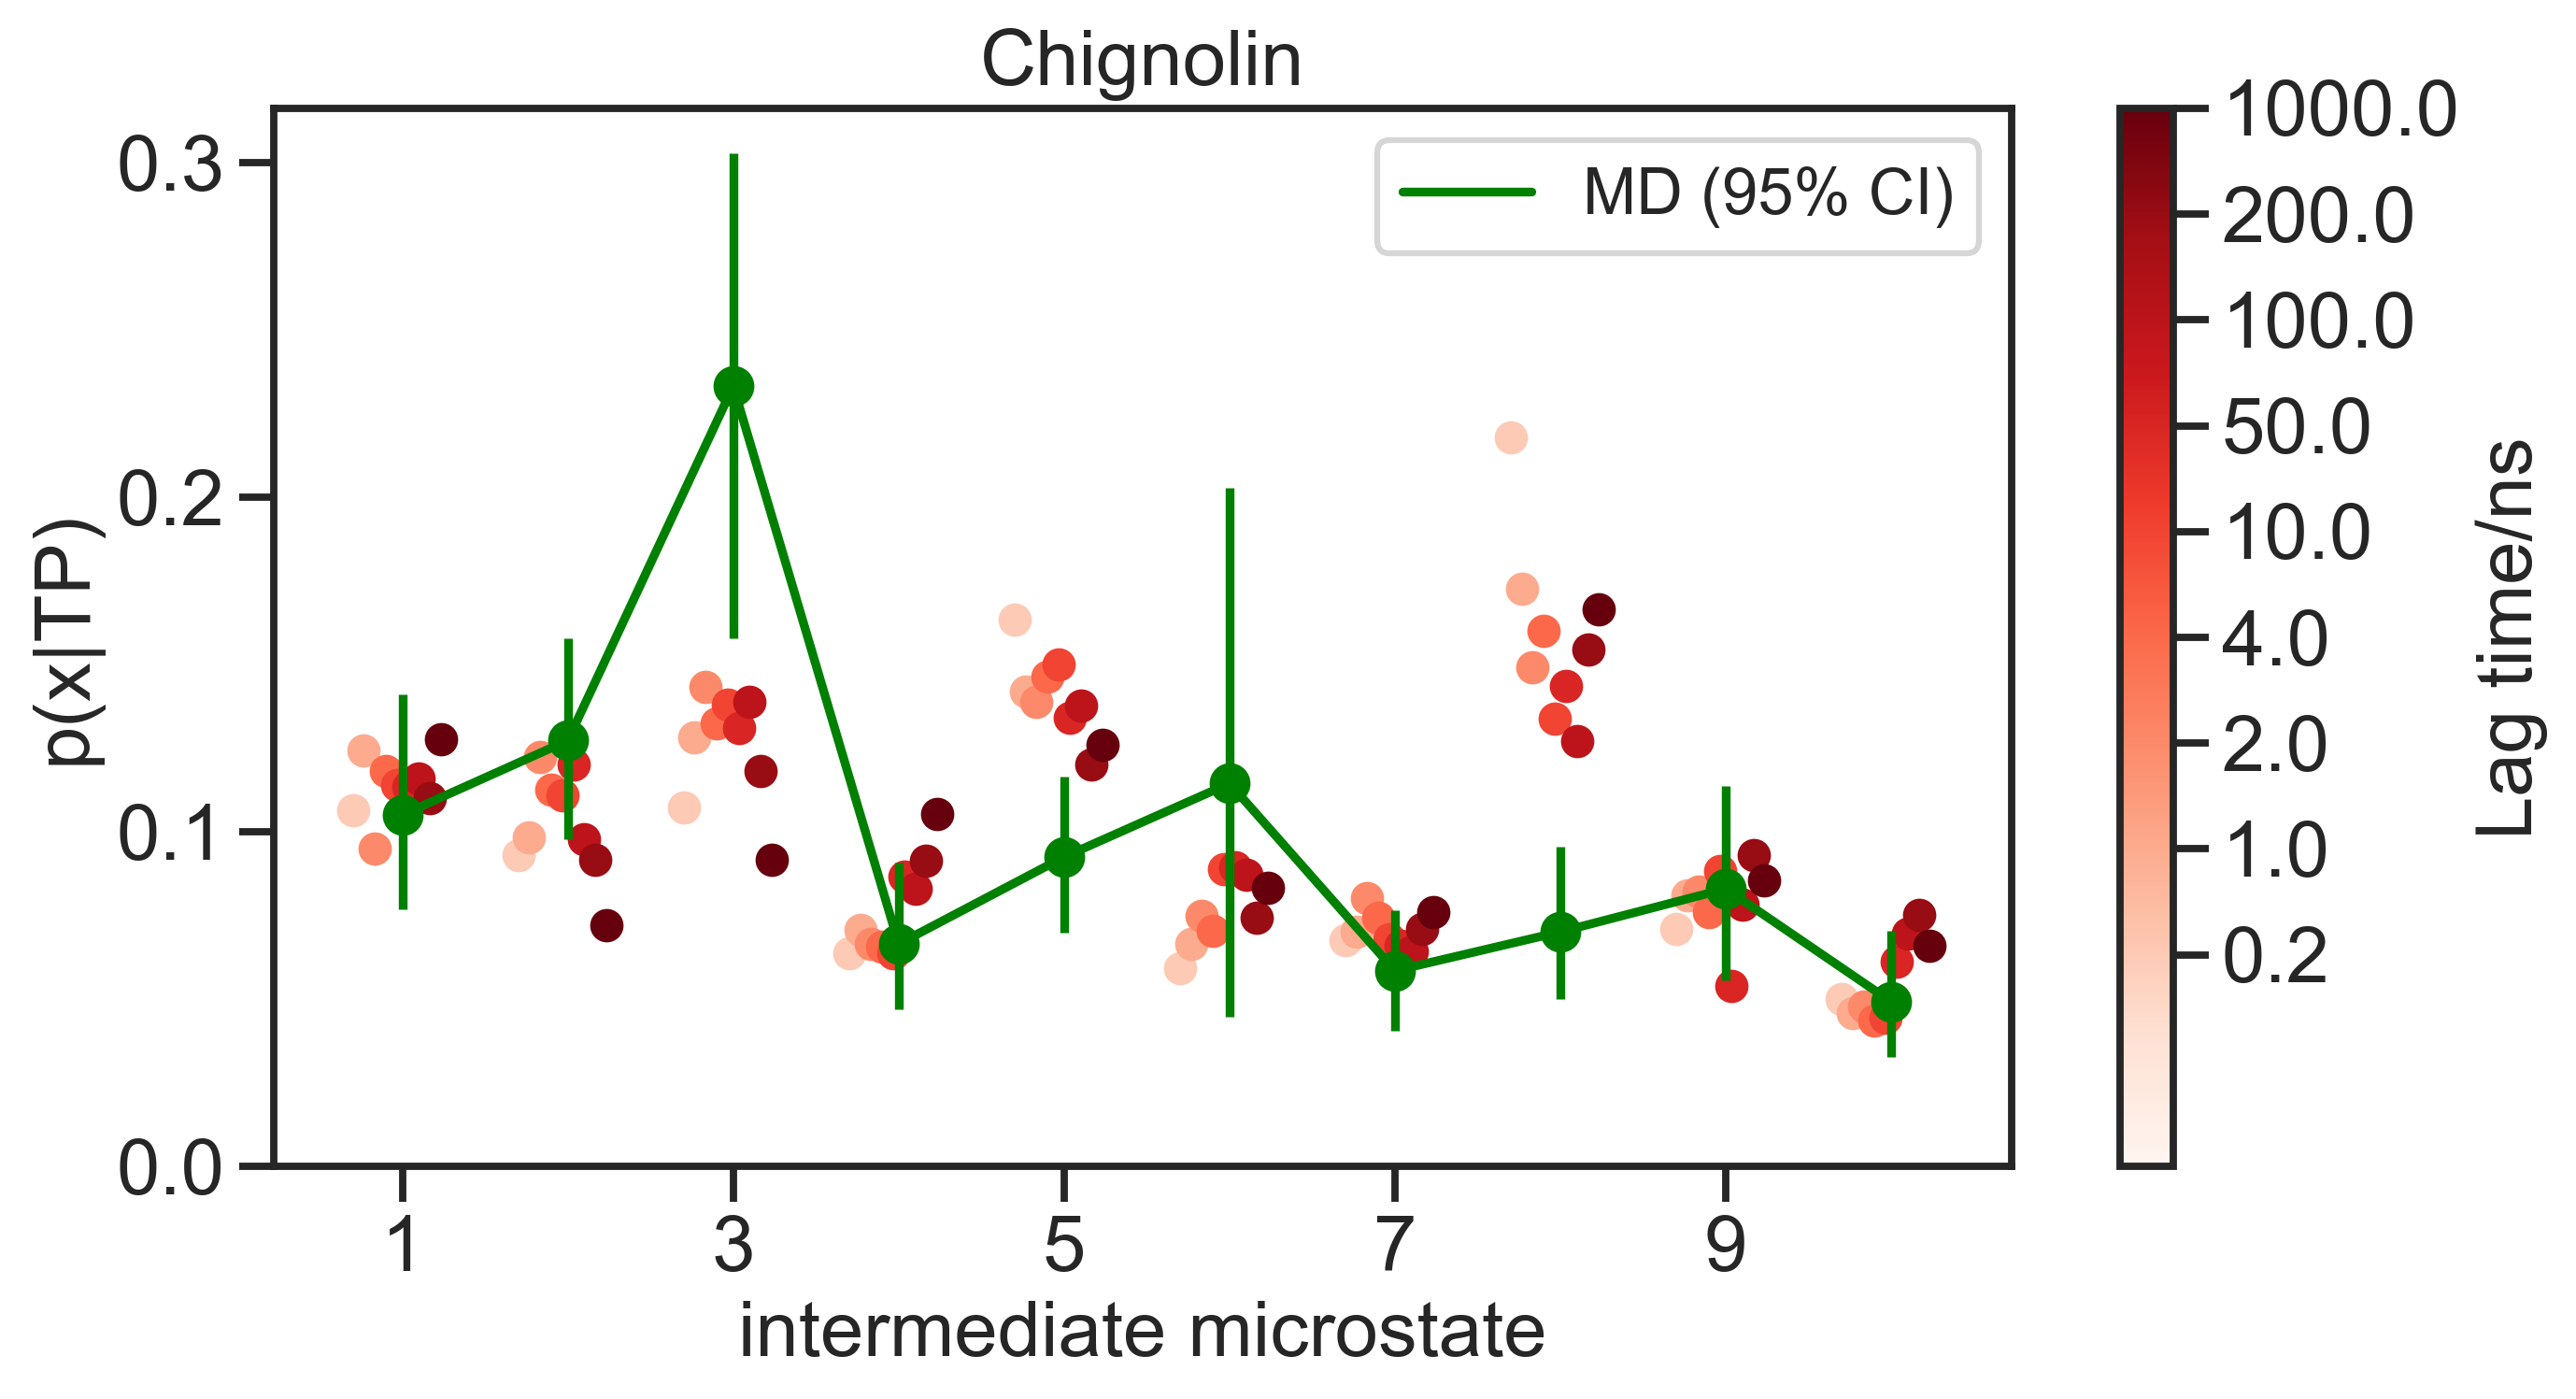

In [224]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msm[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('Lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(range(1,11), np.mean(bootstrap_counts, axis=0), color='green', label='MD (95% CI)')
plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], fmt='none', color='green')
plt.scatter(range(1,11), np.mean(bootstrap_counts, axis=0), color='green')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,11,2), fontsize=20)
plt.yticks(np.arange(0, 0.4, 0.1), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

In [38]:
# haMSM

In [40]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [41]:
my_path_ensembleAB = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixAB(), nm_model.stateA, nm_model.stateB, n_paths=1000)
my_path_ensembleBA = DiscretePathEnsemble.from_transition_matrix( nm_model.tmatrixBA(), nm_model.stateB, nm_model.stateA, n_paths=1000)

In [72]:
path_ensemble = my_path_ensembleAB.trajectories + my_path_ensembleBA.trajectories

int_trajs_nm = get_trans_paths_nm(path_ensemble, nm_model)

In [74]:
len(int_trajs_nm)

1080

In [84]:
counts_nm = count_nm(int_trajs_nm)

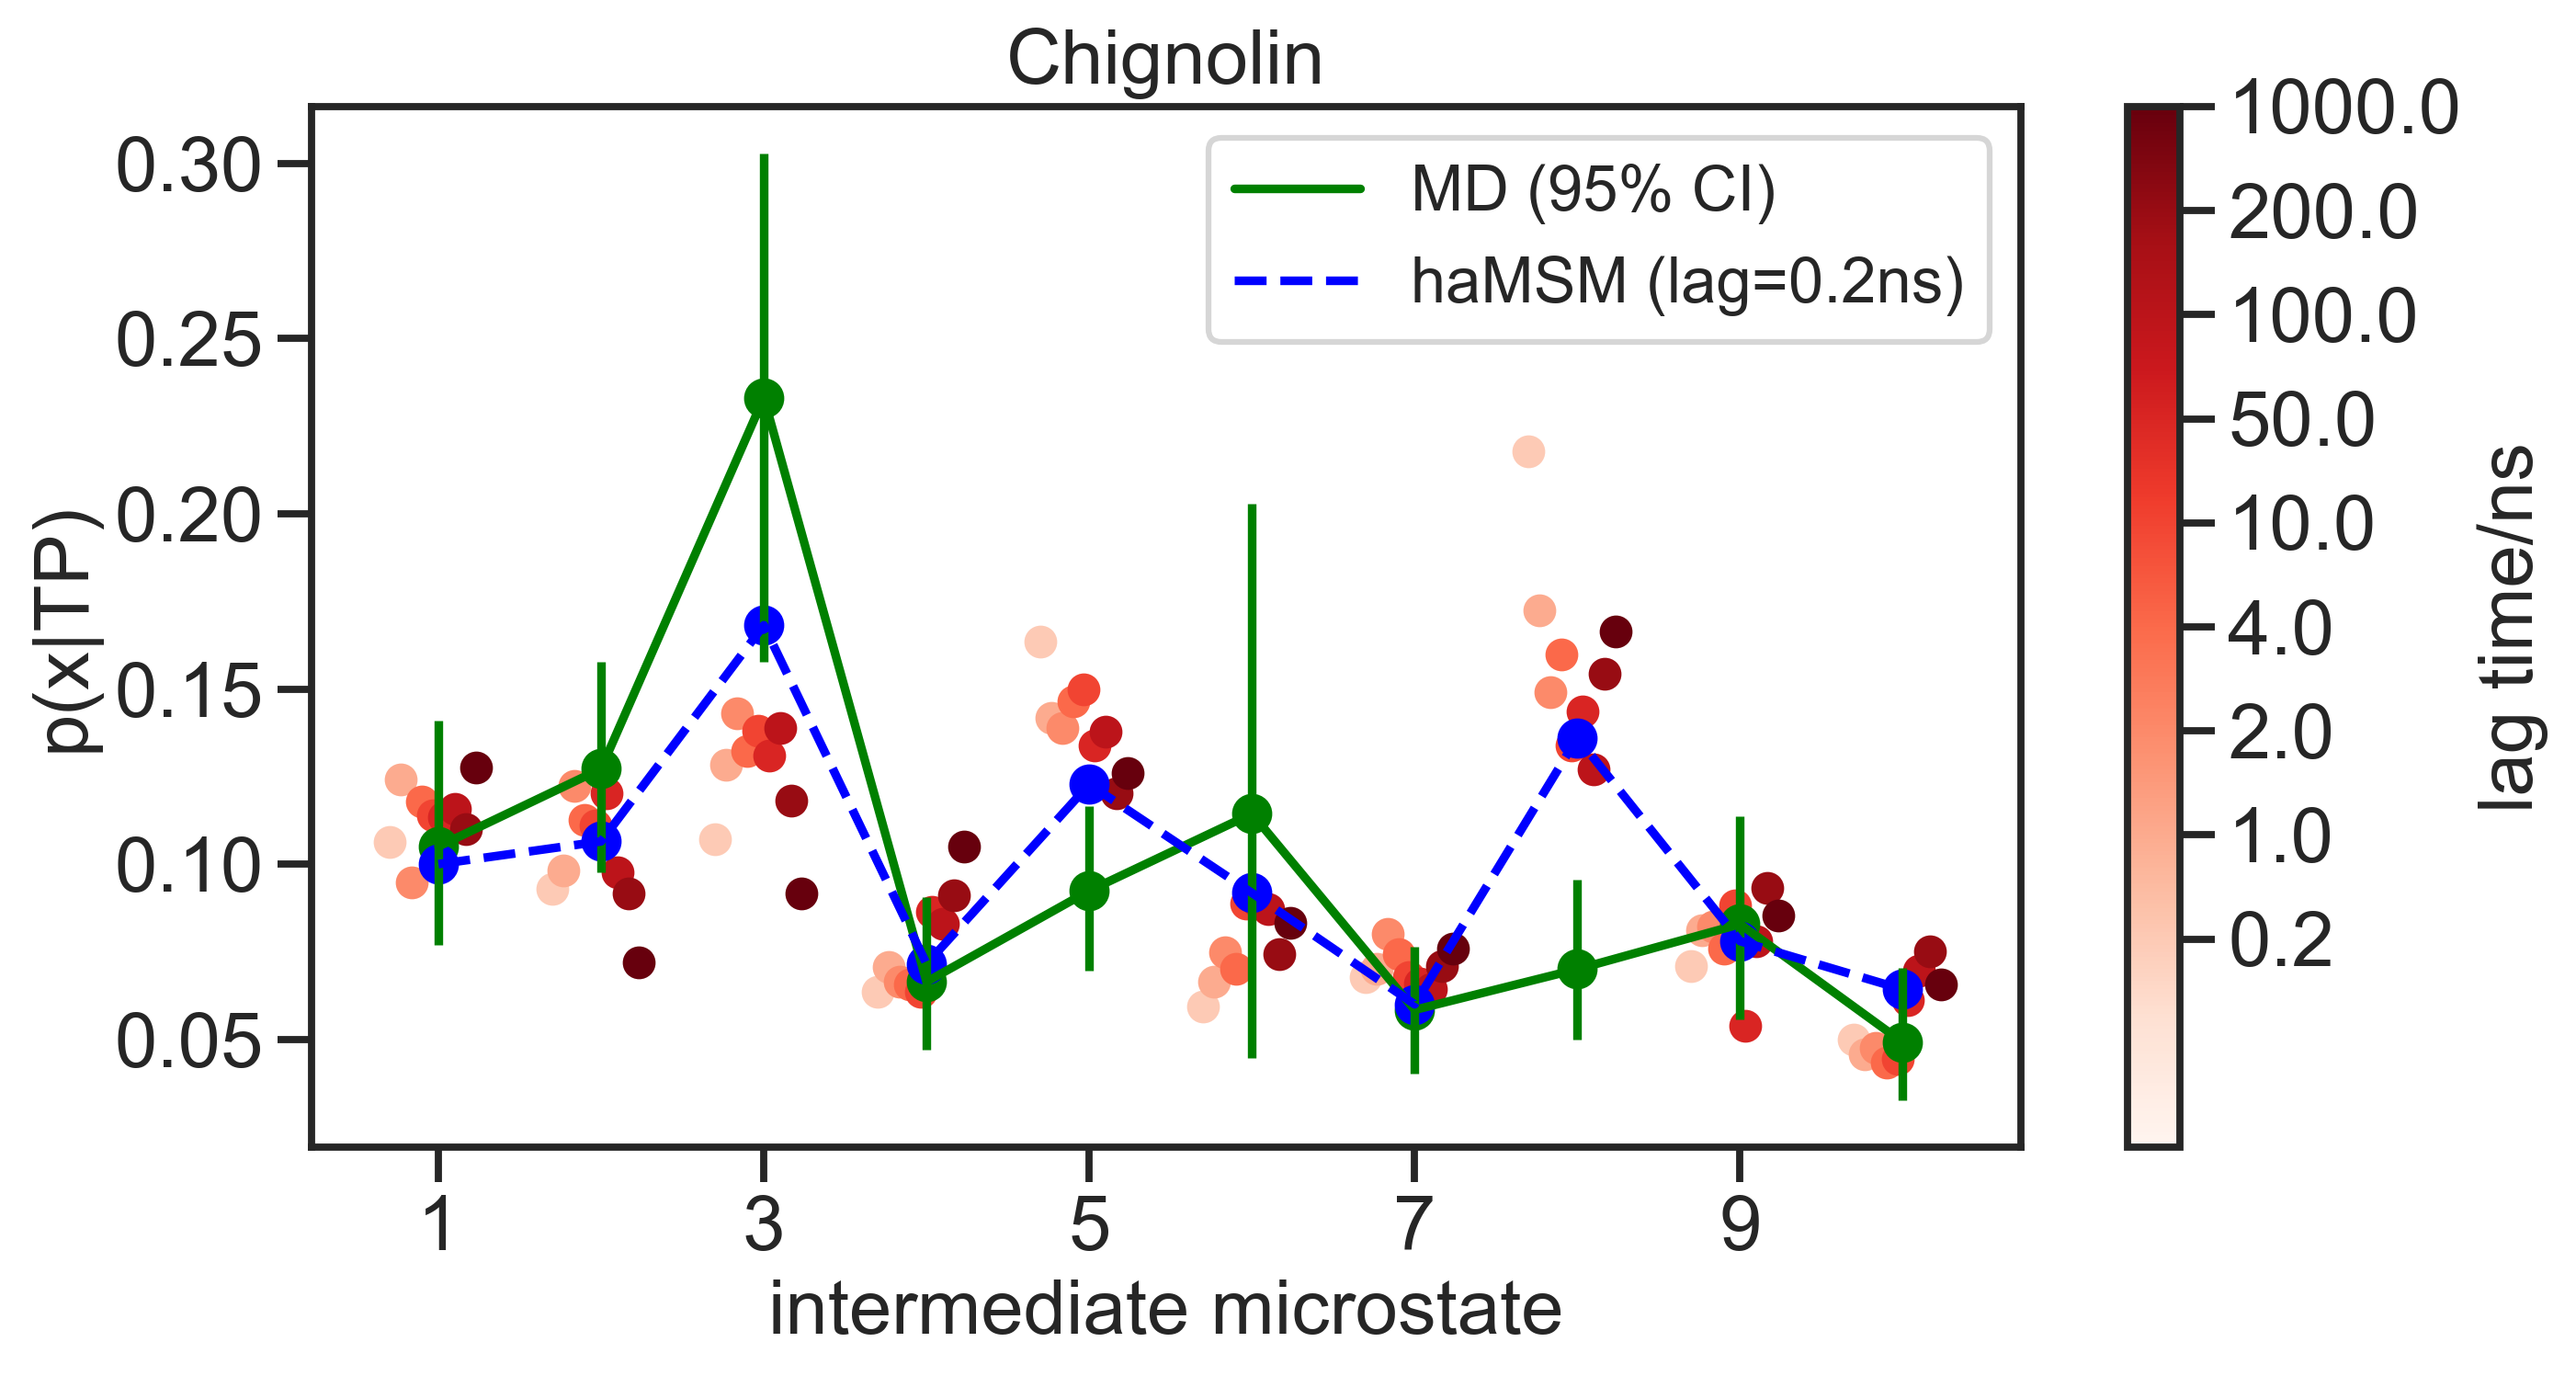

In [225]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_all[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(range(1,11), np.mean(bootstrap_counts, axis=0), color='green', label='MD (95% CI)')
plt.errorbar(range(1,11), np.mean(bootstrap_counts, axis=0), yerr=[(np.mean(bootstrap_counts, axis=0)-np.percentile(bootstrap_counts, 2.5, axis=0)), (np.percentile(bootstrap_counts, 97.5, axis=0)-np.mean(bootstrap_counts, axis=0))], fmt='none', color='green')
plt.scatter(range(1,11), np.mean(bootstrap_counts, axis=0), color='green')

plt.plot(np.arange(1,11), counts_nm, '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(1,11), counts_nm, color='blue')

plt.xlabel('intermediate microstate', fontsize=20)
plt.ylabel('p(x|TP)', fontsize=20)
plt.xticks(np.arange(1,11,2), np.arange(1,10,2), fontsize=20)
plt.yticks(np.arange(0.05, 0.35, 0.05), fontsize=20)
plt.title('Chignolin', fontsize=20)
plt.legend()

plt.show()

## Fundamental Sequences

In [111]:
nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [142]:
ens = DiscretePathEnsemble.from_ensemble(nm_model, nm_model.stateA, nm_model.stateB)

In [145]:
len(ens.trajectories)

200

In [151]:
fs = ens._fundamental_sequences(nm_model.markov_tmatrix)

In [167]:
mdFS_bootstrap = []
mdFSweights_bootstrap = []

for boostrap in range(100):
    fs_ = np.random.choice(fs, len(fs))
    FS, FSweights = weighted_fundamental_sequences_md(fs_)
    mdFS_bootstrap.append(FS)
    mdFSweights_bootstrap.append(FSweights)

In [178]:
mdFSweights_bootstrap_padded = []

mdFS_indexdict = dict()

for i,seq in enumerate(mdFS):
    mdFS_indexdict[seq] = i

for i,seqs in enumerate(mdFS_bootstrap):
    mdFSweights_bootstrap_padded.append([0 for x in range(len(mdFS))])
    for j,seq in enumerate(seqs):
        mdFSweights_bootstrap_padded[-1][mdFS_indexdict[seq]] = mdFSweights_bootstrap[i][j]

In [183]:
mdFS, mdFSweights, _ = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS()


nm_model.markovian = True


msmFS, msmFSweights, _ = nm_model.weighted_FS()

nm_model.lag_time = 5
msmFS_5, msmFSweights_5, _ = nm_model.weighted_FS()

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS()

nm_model.lag_time = 20
msmFS_20, msmFSweights_20, _ = nm_model.weighted_FS()

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS()

nm_model.lag_time = 250
msmFS_250, msmFSweights_250, _ = nm_model.weighted_FS()

nm_model.lag_time = 500
msmFS_500, msmFSweights_500, _ = nm_model.weighted_FS()

nm_model.lag_time = 1000
msmFS_1000, msmFSweights_1000, _ = nm_model.weighted_FS()

nm_model.lag_time = 5000
msmFS_5000, msmFSweights_5000, _ = nm_model.weighted_FS()


nm_model.lag_time = 1
nm_model.markovian = False

In [195]:
nmFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_5 = []
msmFSweights_temp_10 = []
msmFSweights_temp_20 = []
msmFSweights_temp_50 = []
msmFSweights_temp_250 = []
msmFSweights_temp_500 = []
msmFSweights_temp_1000 = []
msmFSweights_temp_5000 = []

for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
        
    # lag=5
    if element in msmFS_5:
        msmFSweights_temp_5.append(msmFSweights_5[msmFS_5.index(element)])
    else:
        msmFSweights_temp_5.append(0)   
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
        
    # lag=20
    if element in msmFS_20:
        msmFSweights_temp_20.append(msmFSweights_20[msmFS_20.index(element)])
    else:
        msmFSweights_temp_20.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)

    # lag=250
    if element in msmFS_250:
        msmFSweights_temp_250.append(msmFSweights_250[msmFS_250.index(element)])
    else:
        msmFSweights_temp_250.append(0)
        
    # lag=500
    if element in msmFS_500:
        msmFSweights_temp_500.append(msmFSweights_500[msmFS_500.index(element)])
    else:
        msmFSweights_temp_500.append(0)    
    
    # lag=1000
    if element in msmFS_1000:
        msmFSweights_temp_1000.append(msmFSweights_1000[msmFS_1000.index(element)])
    else:
        msmFSweights_temp_1000.append(0)
        
    # lag=5000
    if element in msmFS_5000:
        msmFSweights_temp_5000.append(msmFSweights_5000[msmFS_5000.index(element)])
    else:
        msmFSweights_temp_5000.append(0)
        
msmFSweights_temp_all = [msmFSweights_temp,msmFSweights_temp_5,msmFSweights_temp_10,msmFSweights_temp_20,msmFSweights_temp_50,msmFSweights_temp_250,msmFSweights_temp_500,msmFSweights_temp_1000,msmFSweights_temp_5000]        

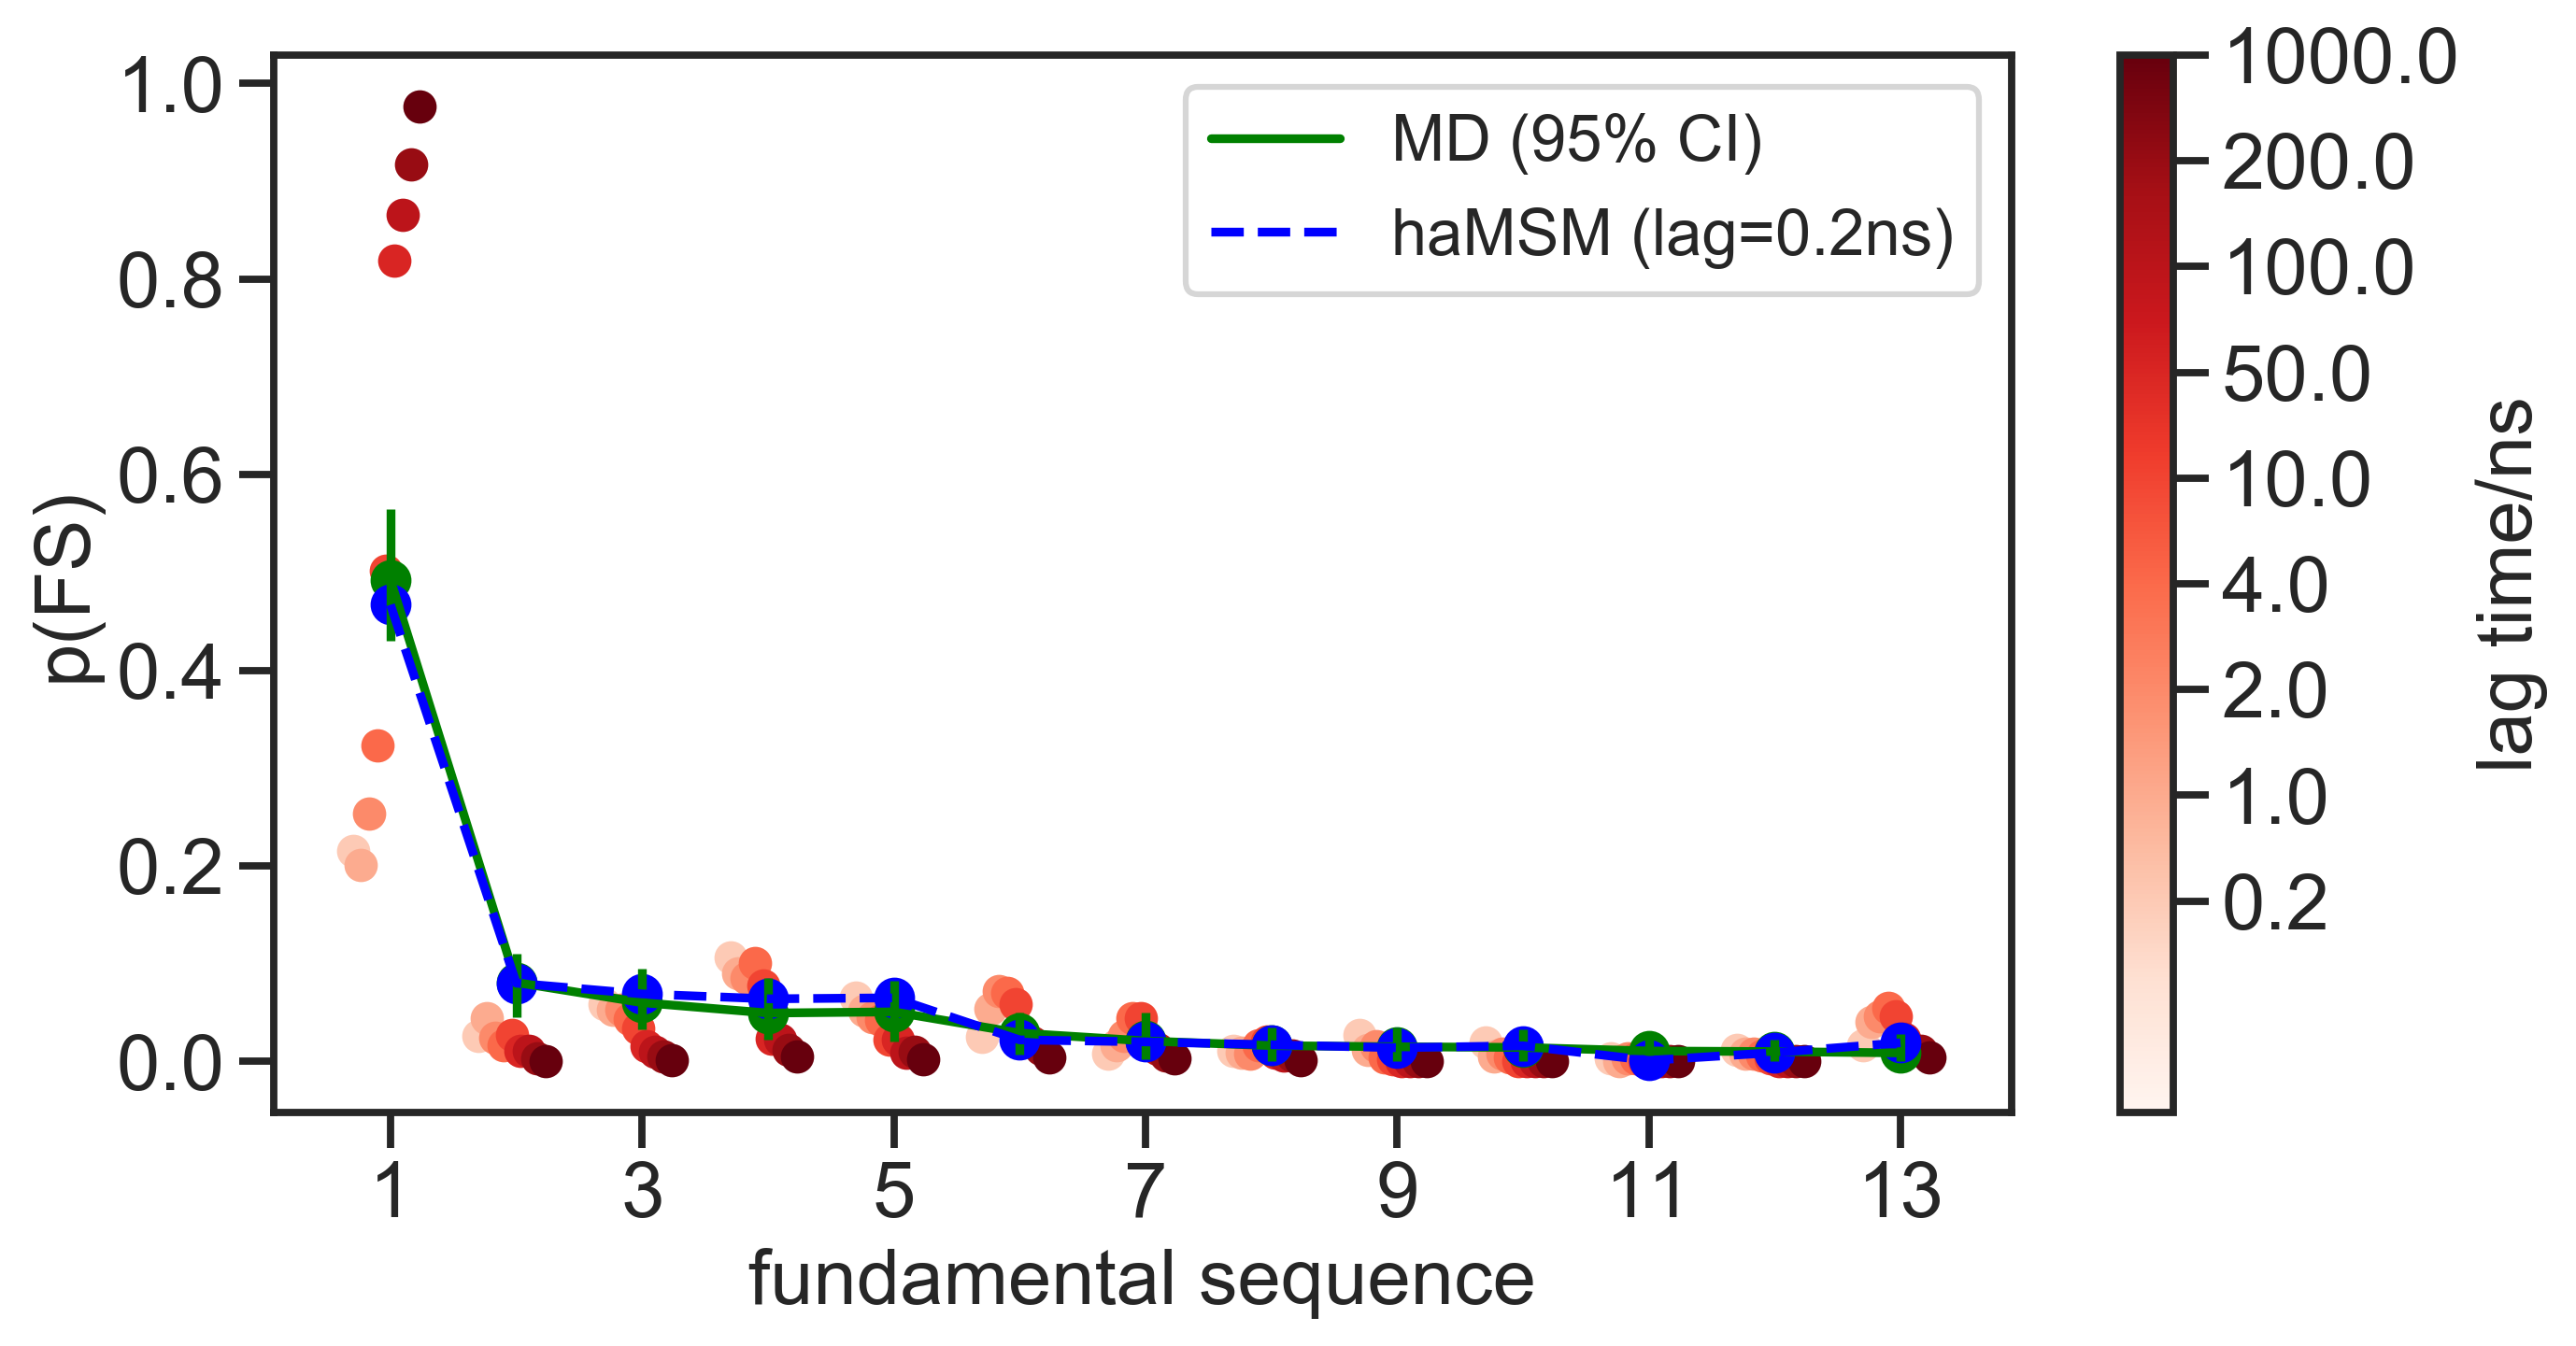

In [236]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(range(1,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[:13], color='green', label='MD (95% CI)')
plt.errorbar(range(1,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[:13]], fmt='none', color='green')
plt.scatter(range(1,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[:13], color='green')

plt.plot(np.arange(1,14), nmFSweights_temp[:13], '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(1,14), nmFSweights_temp[:13], color='blue')

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(1,14,2), np.arange(1,14,2), fontsize=20)
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=20)
plt.legend()

plt.show()

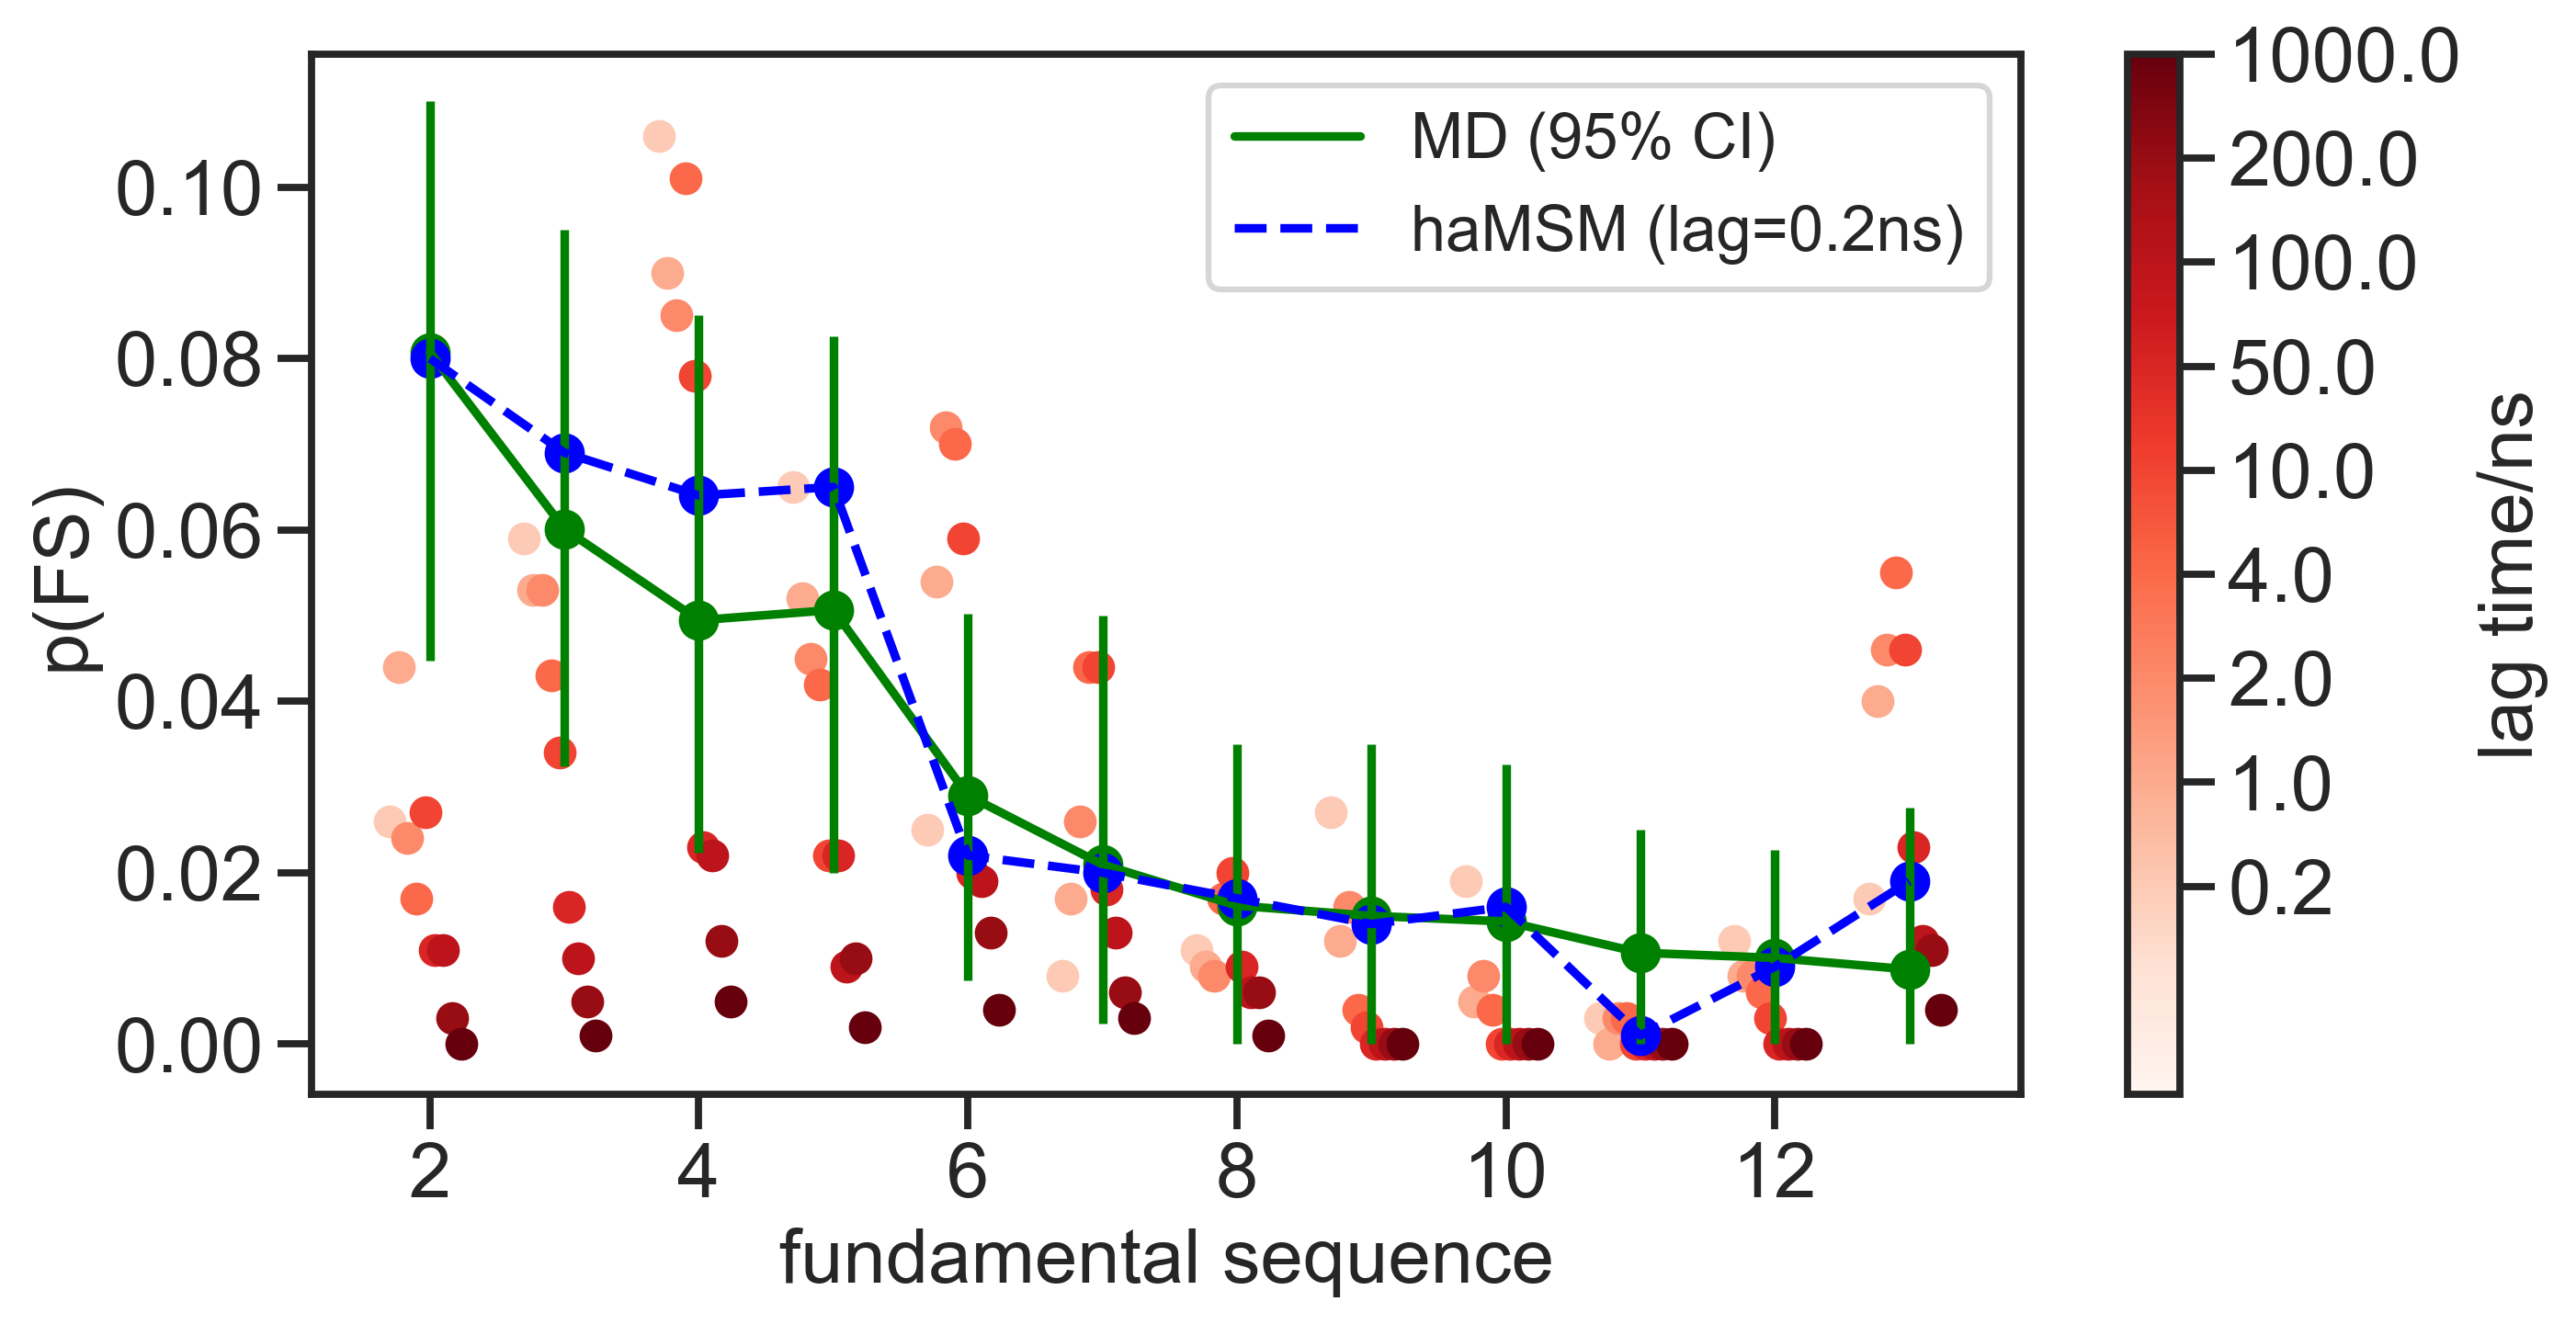

In [241]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(1.7+0.2*msm_index/3,13.5), msmFSweights_temp_all[msm_index][1:13], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('lag time/ns', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.plot(range(2,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[1:13], color='green', label='MD (95% CI)')
plt.errorbar(range(2,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[1:13], yerr=[(np.mean(mdFSweights_bootstrap_padded, axis=0)-np.percentile(mdFSweights_bootstrap_padded, 2.5, axis=0))[1:13], (np.percentile(mdFSweights_bootstrap_padded, 97.5, axis=0)-np.mean(mdFSweights_bootstrap_padded, axis=0))[1:13]], fmt='none', color='green')
plt.scatter(range(2,14), np.mean(mdFSweights_bootstrap_padded, axis=0)[1:13], color='green')

plt.plot(np.arange(2,14), nmFSweights_temp[1:13], '--', color='blue', label='haMSM (lag=0.2ns)')
plt.scatter(np.arange(2,14), nmFSweights_temp[1:13], color='blue')

plt.xlabel('fundamental sequence', fontsize=20)
plt.ylabel('p(FS)', fontsize=20)
plt.xticks(np.arange(2,14,2), np.arange(2,14,2), fontsize=20)
plt.yticks(np.arange(0, 0.12, 0.02), fontsize=20)
plt.legend()

plt.show()